# Plotting the likelihood function across boundaries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
import emcee

from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()

from stardate.lhf import gyro_model
import corner

import stardate as sd
# from stardate.lhf import lnprob

In [2]:
def convective_turnover_time(*args):
    """
    Estimate the convective overturn time using equation 11 in Wright et al.
    (2011): https://arxiv.org/abs/1109.4634
    log tau = 1.16 - 1.49log(M/M⊙) - 0.54log^2(M/M⊙)
    (I assume log is log10)
    params:
    ------
    EITHER:
    mass: (float)
        Mass in Solar units
    OR
    eep: (float)
        The Equivalent evolutionary point of a star. 355 for the Sun.
    age: (float)
        The age of a star in log_10(years).
    feh: (float)
        The metallicity of a star.
    """

    if len(args) > 1:
        # Convert eep, age and feh to mass (mass will be in Solar mass units)
        eep, age, feh = args
        M = mist.mass(eep, age, feh)
    else:
        M = args[0]

    log_tau = 1.16 - 1.49*np.log10(M) - .54*(np.log10(M))**2
    return 10**log_tau


def gyro_model_rossby(log10_age, bv, mass, rossby=True, Ro_cutoff=2.16):
    """
    Predict a rotation period from an age and color (and mass if the rossby cutoff model is used).
    params:
    -------
    args: (list)
        Either containing [log10_age, bv] in which case the standard gyro model will be used.
        Or [mass, log10_age, bv] in which case the Rossby number cutoff model will be used.
    Ro_cutoff: (float, optional)
        The critical Rossby number after which stars retain their rotation period.
        This is 2.16 in van Saders et al. (2016) and 2.08 in van Saders et al. (2018).
    """
    # Angus et al. (2015) parameters.
    a, b, c, n = [.4, .31, .45, .55]
    
    age_myr = (10**log10_age)*1e-6

    if not rossby:  # If Rossby model is switched off
        # Standard gyro model
        log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
        return 10**log_P
    
    # Otherwise the Rossby model is switched on.
    # Calculate the maximum theoretical rotation period for a star of this mass.
    pmax = Ro_cutoff * convective_turnover_time(mass)

    # Calculate the age at which this star would reach pmax, based on its B-V color.
    age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
    log10_age_thresh = np.log10(age_thresh_myr*1e6)
    
    # If the star is younger than this critical age, predict a rotation from age and color.
    if log10_age < log10_age_thresh:
        log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
        
    # If the star is older than this age, return the maximum rotation period it could have.
    else:
        log_P = np.log10(pmax)
    return 10**log_P

2.1446760098487037


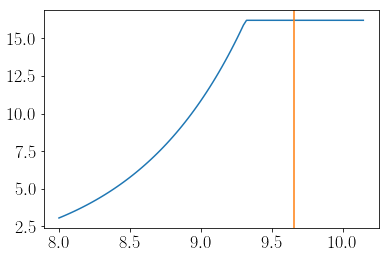

In [8]:
print(31./convective_turnover_time(1.))
ages = np.linspace(8, np.log10(14*1e9), 100)
periods = []
for age in ages:
    periods.append(gyro_model_rossby(age, .65, mass))
plt.plot(ages, periods)
plt.axvline(np.log10(4.56*1e9), color="tab:orange")

In [214]:
def lnprob(lnparams, *args):
    """
    The ln-probability function.
    lnparams are [eep, log10(age [yrs]), [Fe/H], ln(distance [kpc]), A_v]
    If EEP is greater than 425, the star has started evolving up the
    subgiant branch, so it should have a precise isochronal age and an
    unreliable gyro age -- shut gyrochronology off!
    If the Rossby number is greater than 2.16, shut gyrochronology off.
    """
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[3] = np.exp(lnparams[3])

    mod, period, period_err, iso_only, rossby = args

    # If the prior is -inf, don't even try to calculate the isochronal
    # likelihood.
    lnpr = mod.lnprior(params)
    if not np.isfinite(lnpr):
        return lnpr, lnpr

    # If isochrones only, just return the isochronal lhf.
    if iso_only:
        return mod.lnlike(params) + lnpr, lnpr
        
    # Calculate B-V
    mag_pars = (params[0], params[1], params[2], params[3], params[4])
    B = mist.mag["B"](*mag_pars)
    V = mist.mag["V"](*mag_pars)
    bv = B-V
    
    # Check that the period is a positive, finite number. It doesn't matter too much
    # what the lhf is here, as long as it is constant.
    if not period or not np.isfinite(period) or period <= 0.:
        gyro_lnlike = -.5*((5/(20.))**2) - np.log(20.)
    
    # If cool and MS:
    elif bv > .45 and params[0] < 454:
        mass = mist.mass(params[0], params[1], params[2])
        gyro_lnlike = -.5*((period - gyro_model_rossby(params[1], bv, mass, rossby))
                            /period_err)**2 - np.log(period_err)
            

    # If evolved or hot, use a broad gaussian model for rotation.
    else: 
        gyro_lnlike = -.5*(((np.log10(period) - 1.)/(1.))**2) \
            - np.log(1.)
#         gyro_lnlike = -.5*(((np.log10(period) - .5)/(.55))**2) \
#             - np.log(.55)
#         gyro_lnlike = -.5*((period - .5/.55)**2)
#         gyro_lnlike = -.5*((period - 5)/(period_err*20.))**2 - np.log(20.*period_err)
#         gyro_lnlike = -.5*((period - .5)/(period_err*100))**2 - np.log(100*period_err)

    return mod.lnlike(params) + gyro_lnlike + lnpr, mod.lnlike(params), gyro_lnlike, lnpr

In [215]:
def set_params(eep, age, feh):
    """
    Set EEP, age and feh and determine other parameters from those.
    """
    logg = mist.logg(eep, age, feh)
    teff = mist.Teff(eep, age, feh)
    iso_params = pd.DataFrame(dict({"teff": (teff, 10),
                                    "logg": (logg, .05),
                                    "feh": (0., .001),
                                    "parallax": (1., .01)}))  # mas
    mag_pars = [eep, age, feh, 1000., 0.]
    bv = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)
    prot = gyro_model_rossby(age, bv, mist.mass(eep, age, feh))
    return iso_params, mist.mass(eep, age, feh), bv, prot

In [216]:
def calc_lnprob(eep, age, feh):
    # Calculate the lnprob
    lnparams = [eep, age, feh, np.log(1000.), 0.]
    return lnprob(lnparams, *args)

In [217]:
true_eep, true_age, true_feh = 405, np.log10(2.295*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, False]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
# print(prob)

mass =  1.5121592028713062
B-V =  0.42914088866386635
prot =  16.197038191678867
rossby =  2.1600000000000006


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in double_scalars


In [221]:
N = 100
eeps = np.linspace(300, 490, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 702.58it/s]


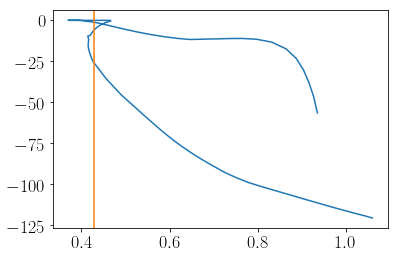

In [222]:
plt.plot(bvs, iso_probs)
plt.axvline(bv, color="tab:orange")

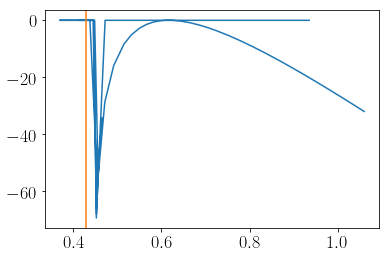

In [223]:
plt.plot(bvs, gyro_probs)
plt.axvline(bv, color="tab:orange")

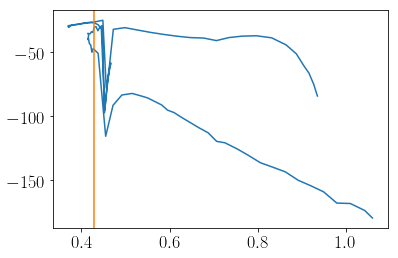

In [224]:
plt.plot(bvs, probs)
plt.axvline(bv, color="tab:orange")

In [225]:
true_eep, true_age, true_feh = 450, np.log10(3*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
# print(prob)

mass =  1.3894404771515674
B-V =  0.46942811626649394
prot =  9.635853677196272
rossby =  1.1161934562119435


In [226]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 750.60it/s]


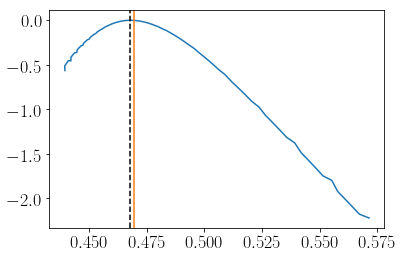

In [227]:
plt.plot(bvs, iso_probs)
plt.axvline(bv, color="tab:orange")
plt.axvline(bvs[iso_probs == max(iso_probs)], color="k", ls="--")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

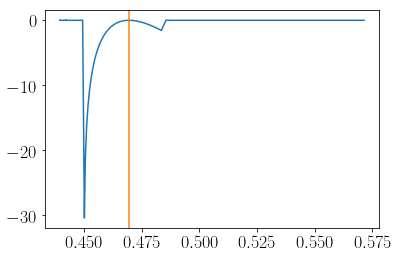

In [228]:
plt.plot(bvs, gyro_probs)
plt.axvline(bv, color="tab:orange")
plt.axvline(bvs[gyro_probs == max(gyro_probs[gyro_probs<0])], color="k", ls="--")
# print(gyro_probs)

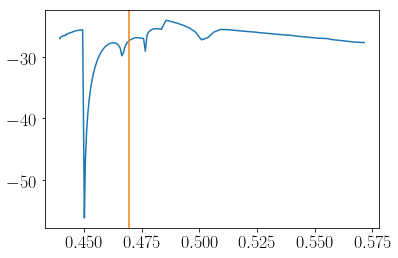

In [229]:
plt.plot(bvs, probs)
plt.axvline(bv, color="tab:orange")

Now look at giants.

In [1000]:
true_eep, true_age, true_feh = 450, np.log10(4*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
print(prob)

mass =  1.2742894399687188
B-V =  0.5174999221524725
prot =  16.606457595890287
rossby =  1.6715154137562216
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [1001]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 641.08it/s]


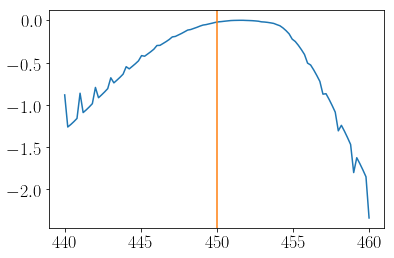

In [1002]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

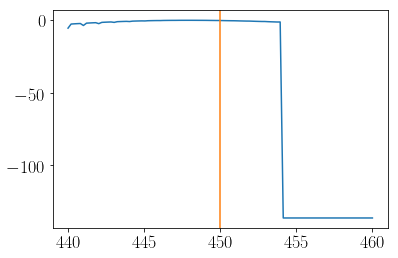

In [1003]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

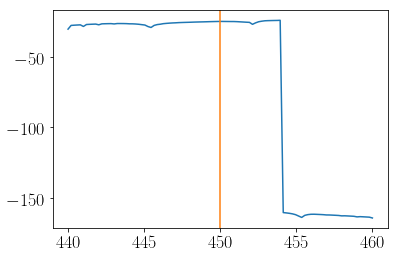

In [1004]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

In [1005]:
true_eep, true_age, true_feh = 458, np.log10(4*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
print(prob)

mass =  1.2882046297409566
B-V =  0.5892736204273774
prot =  20.78702482864032
rossby =  2.1291289772100703
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [1006]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 687.25it/s]


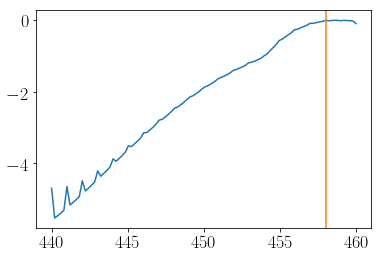

In [1007]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

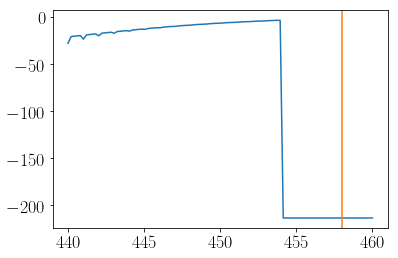

In [1008]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

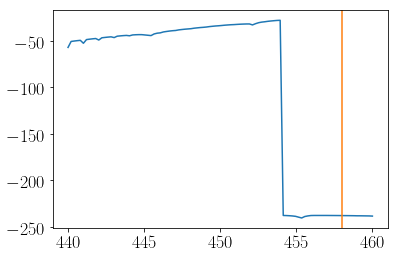

In [1009]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

A star past the rossby threshold

In [1010]:
true_eep, true_age, true_feh = 420, np.log10(5.5*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
print(prob)

mass =  1.1172675385790234
B-V =  0.5315589406153691
prot =  20.98049155437155
rossby =  1.7172051415350682
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [1011]:
N = 100
eeps = np.linspace(300, 400, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 667.75it/s]


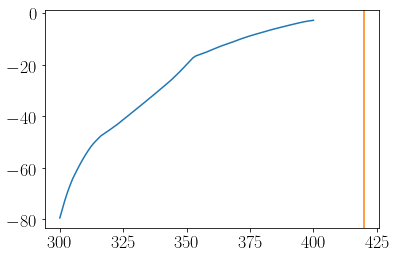

In [1012]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

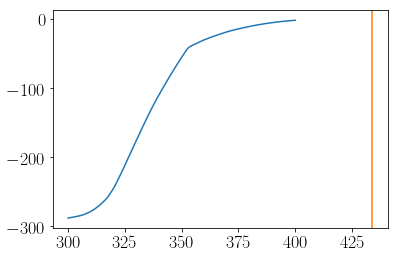

In [894]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

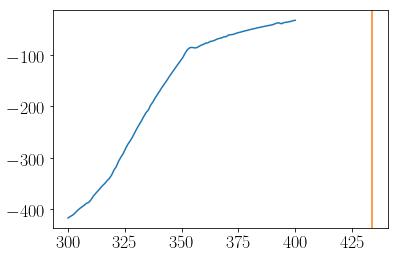

In [895]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

In [530]:
N = 100000
ages = np.random.uniform(5., np.log10(13.8*1e9), N)
eeps = np.random.uniform(198, 490, N)
fehs = np.random.randn(N)*.2
distances = np.random.uniform(10., 1000., N)
avs = np.random.uniform(0., .2, N)

Find all the places where this combination produces B-V = .45

In [428]:
bv_map, teffs, loggs, prots = [np.zeros(N) for i in range(4)]
for i in range(N):
    mag_pars = [eeps[i], ages[i], fehs[i], distances[i], avs[i]]
    bv_map[i] = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)
    prots[i] = gyro_model(ages[i], bv_map[i])
    teffs[i] = mist.Teff(eeps[i], ages[i], fehs[i])
    loggs[i] = mist.logg(eeps[i], ages[i], fehs[i])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:43: RuntimeWarning: invalid value encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


(5.5, 2.5)

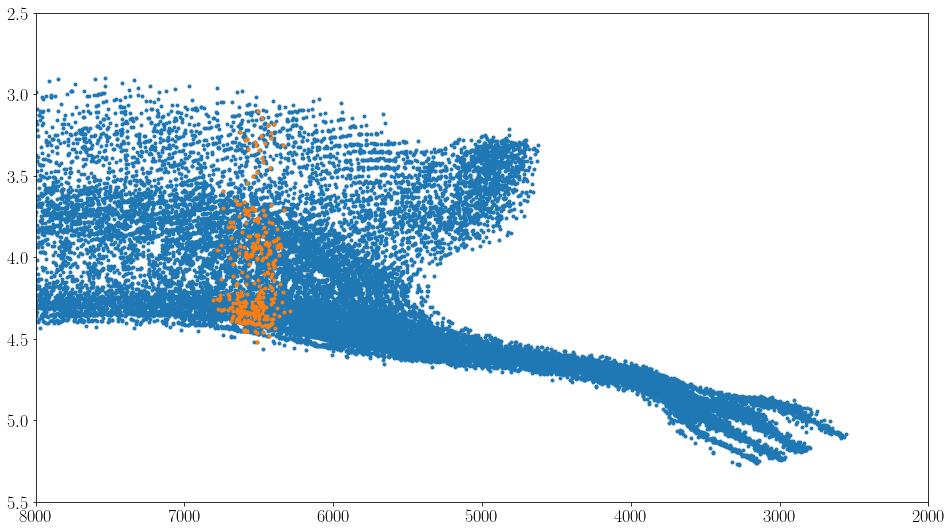

In [429]:
plt.figure(figsize=(16, 9))
# plt.scatter(teffs, loggs, c=bv_map)
# plt.colorbar()
plt.plot(teffs, loggs, ".")
bv_mask = (.45 < bv_map) * (bv_map < .46)
plt.plot(teffs[bv_mask], loggs[bv_mask], ".", color="tab:orange")
plt.xlim(8000, 2000)
plt.ylim(5.5, 2.5)

I could calculate gyro_lnprob for stars with a range of parameters and rotation periods at the border. And find the minimum lnprob. I would compute a lnprob for the orange stars over a range of rotation periods. Then I could look up the nearest star in the catalog and assign a lnprob based 

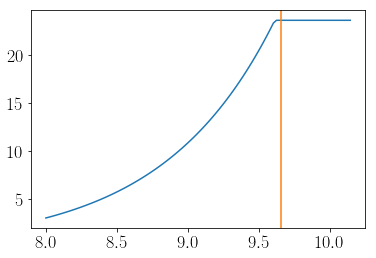

In [636]:
ages = np.linspace(8, np.log10(14*1e9), 100)
mass = 1.2
periods = []
for age in ages:
    periods.append(gyro_model_rossby(mass, age, .65))
plt.plot(ages, periods)
plt.axvline(np.log10(4.56*1e9), color="tab:orange")

In [582]:
pmax, bv = 25, .65
a, b, c, n = [.4, .31, .45, .55]
(pmax/(a*(bv-c)**b))**(1./n)

4562.483498355086

In [583]:
pmax = 2.16 * convective_turnover_time(mass)

Find the B-V that corresponds to bp-rp = 2.4

In [737]:
df = pd.read_csv("data/praesepe.csv")
m = (2.38 < df.bp.values - df.rp.values) * (df.bp.values - df.rp.values < 2.41)
for i in range(sum(m)):
    print(df.bp.values[m][i], df.rp.values[m][i], df.parallax.values[m][i], 
          df.parallax_err.values[m][i], df.bp.values[m][i] - df.rp.values[m][i])

16.90842 14.523178 5.468079785987519 0.08370221098483661 2.385242
16.835106 14.427689 5.194170450880093 0.2518898423029565 2.407416999999999
16.948387 14.546851 5.279415275413722 0.06128636587163337 2.401536
16.870617000000003 14.469619 5.576882243267776 0.07028991516732537 2.400998000000003


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [740]:
iso_params = pd.DataFrame(dict({"bp": (16.90842, .001),
                                "rp": (14.523178, .001), 
                                "parallax": (5.468079785987519, .08)}))
model = StarModel(mist, *iso_params)
model.fit()
# mag_pars = [eep, age, feh, 1000., 0.]
# bv = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)

FileNotFoundError: File b'bp' does not exist